In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from wpythtb import Model, Bloch, K_mesh, Wannier
from models import *
import matplotlib.pyplot as plt
from functools import partial
from itertools import product
import math
import matplotlib.pyplot as plt

%load_ext line_profiler
%timeit

/Users/treycole/Repos/WanPy/dev


In [2]:
def finite_diff_coeffs(order_eps, derivative_order=1, mode='central'):
    """
    Compute finite difference coefficients using the inverse of the Vandermonde matrix.

    Parameters:
        stencil_points (array-like): The relative positions of the stencil points (e.g., [-2, -1, 0, 1, 2]).
        derivative_order (int): Order of the derivative to approximate (default is first derivative).

    Returns:
        coeffs (numpy array): Finite difference coefficients for the given stencil.
    """
    if mode not in ["central", "forward", "backward"]:
        raise ValueError("Mode must be 'central', 'forward', or 'backward'.")
    
    num_points = derivative_order + order_eps  

    if mode == "central":
        if num_points % 2 == 0:
            num_points += 1
        half_span = num_points//2
        stencil = np.arange(-half_span, half_span + 1)

    elif mode == "forward":
        stencil = np.arange(0, num_points)

    elif mode == "backward":
        stencil = np.arange(-num_points+1, 1)

    A = np.vander(stencil, increasing=True).T  # Vandermonde matrix
    b = np.zeros(num_points)
    b[derivative_order] = math.factorial(derivative_order) # Right-hand side for the desired derivative

    coeffs = np.linalg.solve(A, b)  # Solve system Ax = b
    return coeffs, stencil

In [3]:
coeffs, stencil = finite_diff_coeffs(1, mode='central')
coeffs

array([-0.5,  0. ,  0.5])

In [4]:
stencil

array([-1,  0,  1])

In [5]:
def fu_kane_mele(t, soc, m, beta):
    t, soc, m, beta
    # set up Fu-Kane-Mele model
    lat = [[0, 1, 1], [1, 0, 1], [1, 1, 0]]
    orb = [[0, 0, 0], [0.25, 0.25, 0.25]]
    model = Model(3, 3, lat, orb, nspin=2)

    h = m*np.sin(beta)*np.array([1,1,1])
    dt = m*np.cos(beta)

    h0 = [0] + list(h)
    h1 = [0] + list(-h)

    model.set_onsite(h0, 0)
    model.set_onsite(h1, 1)

    # spin-independent first-neighbor hops
    for lvec in ([-1, 0, 0], [0, -1, 0], [0, 0, -1]):
        model.set_hop(t, 0, 1, lvec)
    model.set_hop(3*t + dt, 0, 1, [0, 0, 0],mode="add")
    # model.set_hop(t + dt, 0, 1, [0, 0, 0], mode="add")

    # spin-dependent second-neighbor hops
    lvec_list = ([1, 0, 0], [0, 1, 0], [0, 0, 1], [-1, 1, 0], [0, -1, 1], [1, 0, -1])
    dir_list=([0, 1, -1], [-1, 0, 1], [1, -1, 0], [1, 1, 0], [0, 1, 1], [1, 0, 1])
    for j in range(6):
        spin = np.array([0.]+dir_list[j])
        model.set_hop( 1j*soc*spin, 0, 0, lvec_list[j])
        model.set_hop(-1j*soc*spin, 1, 1, lvec_list[j])

    return model

In [6]:
def get_periodic_H(model, H_flat, k_vals):
    orb_vecs = model.get_orb_vecs()
    orb_vec_diff = orb_vecs[:, None, :] - orb_vecs[None, :, :]
    # orb_phase = np.exp(1j * 2 * np.pi * np.einsum('ijm, ...m->...ij', orb_vec_diff, k_vals))
    orb_phase = np.exp(1j * 2 * np.pi * np.matmul(orb_vec_diff, k_vals.T)).transpose(2,0,1)
    H_per_flat = H_flat * orb_phase
    return H_per_flat


def vel_op_fin_diff(model, H_flat, k_vals, dk, order_eps=1, mode='central'):
    """
    Compute velocity operators using finite differences.
    
    Parameters:
        H_mesh: ndarray of shape (Nk, M, M)
            The Hamiltonian on the parameter grid.
        dk: list of float
            Step sizes in each parameter direction.
    
    Returns:
        v_mu_fd: list of ndarray
            Velocity operators for each parameter direction.
    # """

    # recip_lat_vecs = model.get_recip_lat_vecs()
    # recip_basis = recip_lat_vecs/ np.linalg.norm(recip_lat_vecs, axis=1, keepdims=True)
    # g = recip_basis @ recip_basis.T
    # sqrt_mtrc = np.sqrt(np.linalg.det(g))
    # g_inv = np.linalg.inv(g)

    # dk = np.einsum("ij, j -> i", g_inv, dk)

    # assume only k for now
    dim_param = model._dim_k # Number of parameters (dimensions)
    # assume equal number of mesh points along each dimension
    nks = ( int(H_flat.shape[0]**(1/dim_param)),)*dim_param

    # Switch to periodic gauge H(k) = H(k+G) 
    H_flat = get_periodic_H(model, H_flat, k_vals)
    H_mesh = H_flat.reshape(*nks, model._norb, model._norb)
    v_mu_fd = np.zeros((dim_param, *H_mesh.shape), dtype=complex)

    # Compute Jacobian
    recip_lat_vecs = model.get_recip_lat_vecs()
    inv_recip_lat = np.linalg.inv(recip_lat_vecs)
 
    for mu in range(dim_param):
        coeffs, stencil = finite_diff_coeffs(order_eps=order_eps, mode=mode)

        derivative_sum = np.zeros_like(H_mesh)

        for s, c in zip(stencil, coeffs):
            H_shifted = np.roll(H_mesh, shift=-s, axis=mu)
            derivative_sum += c * H_shifted

        v_mu_fd[mu] = derivative_sum / (dk[mu])

        # Ensure Hermitian symmetry
        v_mu_fd[mu] = 0.5 * (v_mu_fd[mu] + np.conj(v_mu_fd[mu].swapaxes(-1, -2)))

    return v_mu_fd


def vel_op_comm(model, k_pts):
    return



def berry_curvature(model, v_k, H_flat, k_pts, occ_idxs=None, periodic_gauge=False):
    """
    Compute Berry curvature using a more efficient vectorized approach.
    
    Parameters:
        model: Tight-binding model.
        v_k: Velocity operator, shape (Nk, dim_k, n_orb, n_orb).
        H_flat: Hamiltonian matrix, shape (Nk, n_orb, n_orb).
        k_pts: k-point grid, shape (Nk, dim_k).
        occ_idxs: Indices of occupied bands. If None, assumes half-filled system.
        periodic_gauge (bool): Whether to use a periodic gauge for the Hamiltonian.
    
    Returns:
        b_curv: Berry curvature tensor, shape (Nk, dim_k, dim_k, n_occ, n_occ).
    """

    if periodic_gauge:
        H_flat = get_periodic_H(model, H_flat, k_pts)

    evals, evecs = np.linalg.eigh(H_flat) # (Nk, n_orb), (Nk, n_orb, n_orb)
    evecs = evecs.swapaxes(-1, -2) # swap for consistent indexing
    
    n_eigs = evecs.shape[1]

    # Identify occupied bands
    if occ_idxs is None:
        occ_idxs =  np.arange(n_eigs//2)
    else:
        occ_idxs = np.array(occ_idxs)

    # Identify conduction bands
    cond_idxs = np.setdiff1d(np.arange(n_eigs), occ_idxs)  # Identify conduction bands

    # Compute energy denominators in vectorized way
    delta_E = evals[..., np.newaxis, :] - evals[..., :, np.newaxis]
    with np.errstate(divide="ignore", invalid="ignore"):  # Suppress warnings
        inv_delta_E = np.where(delta_E != 0, 1 / delta_E, 0)

    # Rotate velocity operators to eigenbasis
    evecs_conj = evecs.conj()[np.newaxis, :, : :]
    evecs_T =  evecs.transpose(0,2,1)[ np.newaxis, :, : :]
    vk_evecT = np.matmul(v_k, evecs_T)
    v_k_rot = np.matmul(evecs_conj, vk_evecT) # (dim_k, n_kpts, n_orb, n_orb)

    # Extract relevant submatrices
    v_occ_cond = v_k_rot[..., occ_idxs, :][..., :, cond_idxs]
    v_cond_occ = v_k_rot[..., cond_idxs, :][..., :, occ_idxs]
    delta_E_occ_cond = inv_delta_E[:, occ_idxs, :][:, :, cond_idxs]

    v_occ_cond = v_occ_cond * delta_E_occ_cond
    v_cond_occ = v_cond_occ * delta_E_occ_cond.swapaxes(-1,-2)

    # Initialize Berry curvature
    b_curv = 1j * ( 
        np.matmul(v_occ_cond[:, None], v_cond_occ[None, :]) 
        - np.matmul(v_occ_cond[None, :], v_cond_occ[:, None])
    )

    return b_curv

In [7]:
# t = 1.0  # spin-independent first-neighbor hop
# soc = 0.125  # spin-dependent second-neighbor hop
# m = 1  # magnetic field magnitude

# nks = 10, 10, 10
# nbeta = 11
# k_vals = np.array(list(product(*[np.linspace(0, 1, nk, endpoint=True) for nk in nks])))
# betas = np.linspace(0, 2*np.pi, nbeta, endpoint=True)

# Hams = np.zeros((len(betas), *nks, 4, 4), dtype=np.complex128)

# for idx, beta in enumerate(betas):
#     fkm_model = fu_kane_mele(t, soc, m, beta)
#     H = fkm_model.get_ham(k_vals)
#     if fkm_model._nspin == 2:
#         # index mapping is (i, a, j, b) -> (2i + a, 2j + b)
#         new_shape = (*nks,) + (2*fkm_model._norb, 2*fkm_model._norb)
#         H = H.reshape(*new_shape)

#     Hams[idx] = H

# recip_lat_vecs = fkm_model.get_recip_lat_vecs()
# dks = np.array([np.linalg.norm(recip_lat_vecs[idx] / nk) for idx, nk in enumerate(nks)])
# dbeta = (betas[1] - betas[0])/nbeta 

In [8]:
# v = velocity_op(Hams, [dks[0], dks[1], dks[2], dbeta])
# Omega_mu_nu = compute_non_abelian_berry_curvature(Hams, [dks[0], dks[1], dks[2], dbeta])

In [ ]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.5

delta = 1
t0 = 1
tp = -0.1

n_super_cell = 2
model = Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
# model = checkerboard(t0, tp, delta).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

nks = 200, 200
k_vals = np.array(list(product(*[np.linspace(0, 1, nk, endpoint=False) for nk in nks])))

H_flat = model.get_ham(k_vals)
H_sq = H_flat.reshape(*nks, model._norb, model._norb)

bloch_wfs = Bloch(model, *nks)
bloch_wfs.solve_model()

lat_vecs = model.get_lat_vecs()
orb_vecs = model.get_orb_vecs()
recip_lat_vecs = model.get_recip_lat_vecs()
n_occ = model.get_num_orbitals()*model._nspin // 2

print(n_occ)
print(orb_vecs)
print(lat_vecs)

(200, 200, 8, 8)
4
[[0.16666667 0.16666667]
 [0.33333333 0.33333333]
 [0.16666667 0.66666667]
 [0.33333333 0.83333333]
 [0.66666667 0.16666667]
 [0.83333333 0.33333333]
 [0.66666667 0.66666667]
 [0.83333333 0.83333333]]
[[2.         0.        ]
 [1.         1.73205081]]
[[ 3.14159265 -1.81379936]
 [ 0.          3.62759873]]


In [10]:
# vel_fd_sq = vel_op_fin_diff(model, H_flat, k_vals, dks, order_eps=9, mode='central')
# vel_fd = vel_fd_sq.reshape(2, np.prod(nks), 8, 8)

# %lprun -f berry_curvature berry_curvature(model, vel_fd, H_flat, k_vals, periodic_gauge=True)

In [55]:
recip_basis = recip_lat_vecs / np.linalg.norm(recip_lat_vecs, axis=1, keepdims=True)
g = recip_basis @ recip_basis.T
sqrt_mtrc = np.sqrt(np.linalg.det(g))

dn_vecs = np.array([1 / (nk) for nk in nks])
dn = np.array([np.linalg.norm(dn) for dn in dn_vecs])
d2n = np.prod(dn) +0j

dk_vecs = np.array([recip_lat_vecs[idx] / (nk) for idx, nk in enumerate(nks)])
dk = np.array([np.linalg.norm(dk) for dk in dk_vecs])
d2k = np.prod(dk)

dV = model.get_recip_vol()/np.prod(nks)

for idx, b in enumerate(recip_lat_vecs):
    print(f"b_{idx} = {b}")
for idx, b in enumerate(dk_vecs):
    print(f"dk_{idx} = {b}")
    
print("Metric tensor g_{ij} = hat{b_i} . hat{b_j}:\n", g)
print("V_{BZ} = det([b1, b2]) =", np.linalg.det(recip_basis))
print("sqrt{det(g)} =",sqrt_mtrc)
print("|b1/nk1| * |b2/nk2| = ", d2k)
print("|b1/nk1| * |b2/nk2| * sqrt{det(g)} =", d2k * sqrt_mtrc)
print("dV = V_{BZ} / (nk1 * nk2) =", dV)

b_0 = [ 3.14159265 -1.81379936]
b_1 = [0.         3.62759873]
dk_0 = [ 0.01570796 -0.009069  ]
dk_1 = [0.         0.01813799]
Metric tensor g_{ij} = hat{b_i} . hat{b_j}:
 [[ 1.  -0.5]
 [-0.5  1. ]]
V_{BZ} = det([b1, b2]) = 0.8660254037844386
sqrt{det(g)} = 0.8660254037844386
|b1/nk1| * |b2/nk2| =  0.00032898681336964537
|b1/nk1| * |b2/nk2| * sqrt{det(g)} = 0.0002849109378882029
dV = V_{BZ} / (nk1 * nk2) = 0.0002849109378882028


In [56]:
vel_fd_sq = vel_op_fin_diff(model, H_flat, k_vals, dk, order_eps=9, mode='central')
vel_fd = vel_fd_sq.reshape(2, np.prod(nks), 8, 8)
# vel_fd = np.einsum("mn, n... -> m...", np.linalg.inv(g), vel_fd)

b_curv_fd = berry_curvature(model, vel_fd, H_flat, k_vals, periodic_gauge=True)

Chern_fd = np.sum(np.trace(b_curv_fd[0, 1], axis1=-1, axis2=-2)) * d2k / (2 * np.pi)
print(f"Chern fd: {Chern_fd.real}")
print(f"Diff fd diff: {abs(Chern_fd) - 1}")

Chern fd: 1.000000000000005
Diff fd diff: 5.10702591327572e-15


In [16]:
b_curv_plaq = bloch_wfs.berry_curv(state_idx=np.arange(n_occ), non_abelian=True, return_flux=False)

Chern_plaq = np.sum(np.trace(b_curv_plaq[0, 1], axis1=-1, axis2=-2))  * d2k * sqrt_mtrc / (2 * np.pi)
print(f"Chern finite plaq: {Chern_plaq.real}")
print(f"Diff fin plaq: {abs(Chern_plaq) - 1}")

[[ 0.01570796 -0.009069  ]
 [ 0.          0.01813799]]
(200, 200, 8, 8)
(200, 200, 4, 8)
0 1
[[ 0.01570796 -0.009069  ]
 [ 0.          0.01813799]]
0.00028491093788820274
[[ 0.          0.01813799]
 [ 0.01570796 -0.009069  ]]
0.00028491093788820274
Chern finite plaq: 1.0000000000000628
Diff fin plaq: 6.283862319378386e-14


In [17]:
vel_comm = model.gen_velocity(k_vals)
# vel_comm = np.einsum("mn, n... -> m...", g, vel_comm)
# vel_comm_sq = vel_comm.reshape(2, *nks, 8, 8)
b_curv_comm = berry_curvature(model, vel_comm, H_flat, k_vals, periodic_gauge=False)

Chern_comm = np.sum(np.trace(b_curv_comm[0, 1], axis1=-1, axis2=-2)) * d2k * sqrt_mtrc  / (2 * np.pi )

print(Chern_comm.real)
print(f"Diff: {abs(Chern_comm.real) - 1}")

1.0000000000000002
Diff: 2.220446049250313e-16


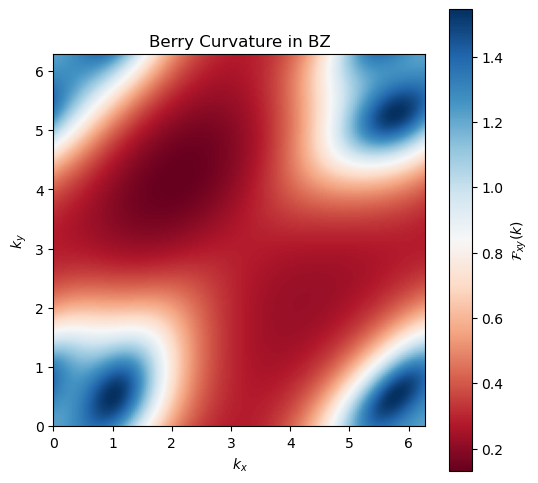

In [19]:
# b_curv_plaq = b_curv_plaq.reshape(2, 2, *nks, 4, 4 )
# Extract Berry curvature for visualization
F_xy = np.trace(b_curv_plaq[0, 1].real, axis1=-2, axis2=-1)

plt.figure(figsize=(6,6))
plt.imshow(F_xy.T, origin='lower', cmap='RdBu', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.colorbar(label=r'$\mathcal{F}_{xy}(k)$')
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("Berry Curvature in BZ")
plt.show()

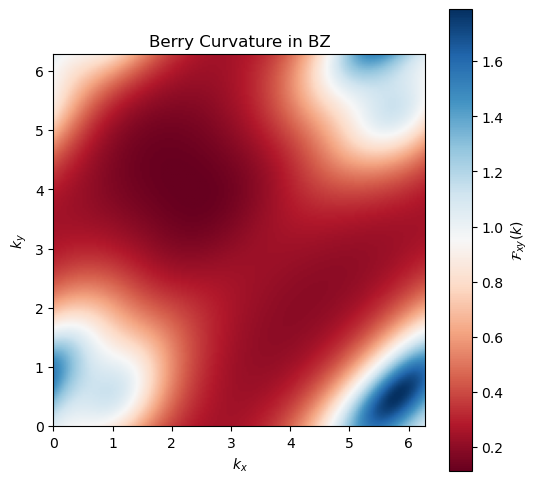

In [20]:
b_curv_fd_sq = b_curv_fd.reshape(2, 2, *nks, 4, 4 )
bc = b_curv_fd_sq[:,:, 1:-1, 1:-1, :, :]
# Extract Berry curvature for visualization
F_xy = np.trace(bc[0, 1].real, axis1=-2, axis2=-1)

plt.figure(figsize=(6,6))
plt.imshow(F_xy.T, origin='lower', cmap='RdBu', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.colorbar(label=r'$\mathcal{F}_{xy}(k)$')
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("Berry Curvature in BZ")
plt.show()

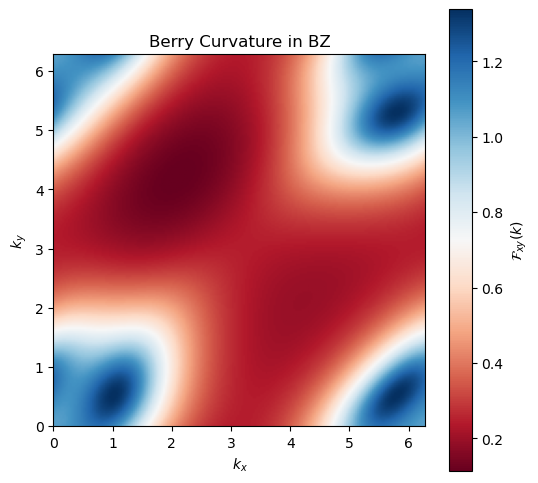

In [21]:
import matplotlib.pyplot as plt

b_curv_comm_sq = b_curv_comm.reshape(2, 2, *nks, 4, 4 )

# Extract Berry curvature for visualization
F_xy = np.trace(b_curv_comm_sq[0, 1].real, axis1=-2, axis2=-1)

plt.figure(figsize=(6,6))
plt.imshow(F_xy.T, origin='lower', cmap='RdBu', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.colorbar(label=r'$\mathcal{F}_{xy}(k)$')
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("Berry Curvature in BZ")
plt.show()